In [1]:
import matplotlib.pyplot as plt
import importlib.util
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import os

from crashpy.utilities import crashMemMap

# To import h and normalize the mass
import pyTNG.cosmology as _cosmo
h = _cosmo.TNGcosmo.h

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
def redshift_to_snap(redshift):
    correspondense = {6:'sn013', 8:'sn008', 10:'sn004'}
    return correspondense[redshift]

In [3]:
def halo_run_path(halo_id, redshift, setting):
    base_path = '/ptmp/mpa/mglatzle/TNG_f_esc'
    path_to_dir = os.path.join(base_path, setting, 'run', 'L35n2160TNG', redshift_to_snap(redshift), f'g{halo_id}')
    return path_to_dir

In [4]:
def get_simulation_paths(path_to_halo):
    path_out =  os.path.join(path_to_halo, 'Output/phys_ic00_rt05.out')
    return path_out

In [5]:
def get_H_map(halo):
    return np.ones(halo[1].shape)-halo[1]

def get_He_map(halo):
    return np.ones(halo[1].shape)-halo[2]-halo[3]

In [6]:
def get_maps(halo_id, redshift, setting, props=None, just_HI=False):
    path_to_halo = halo_run_path(halo_id, redshift, setting)
    if props == None:
        props = ['T', 'xHI', 'xHII', 'xHeI', 'xHeII', 'xHeIII']
    prop_dict = {'T':0, 'xHII':1, 'xHeII':2, 'xHeIII':3}
    path_out = get_simulation_paths(path_to_halo) 
    halo_out = crashMemMap(path_out, 'all')
    
    maps = {}
    maps['out'] = {}
    if just_HI:
        return get_H_map(halo_out)
    for prop in props:
        if prop in prop_dict:
            maps['out'][prop] = halo_out[prop_dict[prop]]
        elif prop == 'xHI':
            maps['out'][prop] = get_H_map(halo_out)
        elif prop == 'xHeI':
            maps['out'][prop] = get_He_map(halo_out)
        else:
            raise ValueError(f'The property {prop} does not exist.')
    return maps

In [32]:
def xHI_histogram(xHI_maps, row, log_scale=True,  bins=16, save=False):
    
    x_label = 'xHI'
    y_label = 'Number of cells'
    
    lower_bound = 0
    upper_bound = 1
    narrowing_factor = 4.5 # For setting the bar widthin the plot
    
    labelsize = 50
    legendsize = 35
    axis_width = 4
    linewidth = 4
    tick_size_major = 16
    tick_size_minor = 8
    tick_width_major = 4
    tick_width_minor = 3
    tick_label_size = 35
    figsize_x = 20
    figsize_y = 15
    title_size = 65
    
    halo_id = row.ID
    stellar_mass = row.StarMass
    fesc1e4 = row.f_esc_1e4
    fesc1e5 = row.f_esc_1e5
    fesc1e6 = row.f_esc_1e6
    
    xHI_1e4 = xHI_maps['1e4']
    xHI_1e5 = xHI_maps['1e5']
    xHI_1e6 = xHI_maps['1e6']

    edges = np.linspace(lower_bound, upper_bound, bins)

    binning_width = edges[1]-edges[0]
    bar_width = binning_width/narrowing_factor

    heights1e4, *_ = plt.hist(xHI_1e4-bar_width, bins=edges-bar_width, width = bar_width, 
                 label=f'1e4: <xHI>={np.average(xHI_1e4):.5f}, fesc={fesc1e4:.5f}')
    heights1e5, *_ = plt.hist(xHI_1e5, bins=edges, width = bar_width, 
                 label=f'1e5: <xHI>={np.average(xHI_1e5):.5f}, fesc={fesc1e5:.5f}')
    heights1e6, *_ = plt.hist(xHI_1e6+bar_width, bins=edges+bar_width, width = bar_width, 
                 label=f'1e6: <xHI>={np.average(xHI_1e6):.5f}, fesc={fesc1e6:.5f}')
    
    #plt.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ratio_height = heights1e5[0]/heights1e6[0]
    ratio_fesc = fesc1e5/fesc1e6
    if log_scale:
        plt.yscale('log')
    if not (halo_id == None):
        plt.title(f'ID:{halo_id}  $log(M\_star)=${np.log10(stellar_mass):.2f}', fontsize=title_size)
    plt.rc('xtick', labelsize=tick_label_size) 
    plt.rc('ytick', labelsize=tick_label_size) 
    plt.xlabel(x_label, fontsize=labelsize)
    plt.ylabel(y_label, fontsize=labelsize)
    plt.rcParams["figure.figsize"] = (figsize_x,figsize_y)
    plt.rc('axes', linewidth=axis_width)
    plt.tick_params(length=tick_size_major, width=tick_width_major)
    plt.tick_params(length=tick_size_minor, width=tick_width_minor, which='minor')
    plt.legend(fontsize = legendsize)
    if save:
        if log_scale:
            plt.savefig(f'/u/ivkos/analysis/plots/xHI/halo_{halo_id}.pdf', bbox_inches = 'tight')
        else:
            plt.savefig(f'/u/ivkos/analysis/plots/xHI/halo_{halo_id}_lin.pdf', bbox_inches = 'tight')
    plt.close()
    return ratio_height, ratio_fesc

In [8]:
def update_df(df):
    mult = 1e10/h
    df['StarMass']= df['HaloMass']*df['FractionStars']*mult
    return

In [1]:
df_1e4_full = pd.read_pickle('dfs/numerical_1e4.pickle')
df_1e5_full = pd.read_pickle('dfs/fid2.pickle')
df_1e6 = pd.read_pickle('dfs/numerical_1e6.pickle')
merge_1 = df_1e5_full.merge(df_1e6[['ID', 'z', 'f_esc']], on=['ID', 'z'], suffixes=['_1e5', '_1e6'])
comparison_df = merge_1.merge(df_1e4_full[['ID', 'z', 'f_esc']], on=['ID', 'z'])
comparison_df['f_esc_1e4'] = comparison_df['f_esc']
update_df(comparison_df)
del df_1e4_full
del df_1e5_full
del df_1e6

NameError: name 'pd' is not defined

In [81]:
settings = ['numerical_1e4', 'fid2', 'numerical_1e6']
keys = ['1e4', '1e5', '1e6']
for _,row in comparison_df.iterrows():
    maps = {}
    for i, setting in enumerate(settings):
        HI_map = get_maps(row.ID, row.z, setting, just_HI=True)
        HI_map = HI_map.flatten()
        maps[keys[i]] = HI_map
    xHI_histogram(xHI_maps = maps, row=row, bins=16, save=False)

In [34]:
settings = ['numerical_1e4', 'fid2', 'numerical_1e6']
keys = ['1e4', '1e5', '1e6']
rel_heights = []
rel_fesc = []
for _,row in comparison_df.iterrows():
    maps = {}
    for i, setting in enumerate(settings):
        HI_map = get_maps(row.ID, row.z, setting, just_HI=True)
        HI_map = HI_map.flatten()
        maps[keys[i]] = HI_map
    ratio_height, ratio_fesc = xHI_histogram(xHI_maps = maps, row=row, log_scale=False, bins=16, save=False)
    rel_heights.append(ratio_height)
    rel_fesc.append(ratio_fesc)

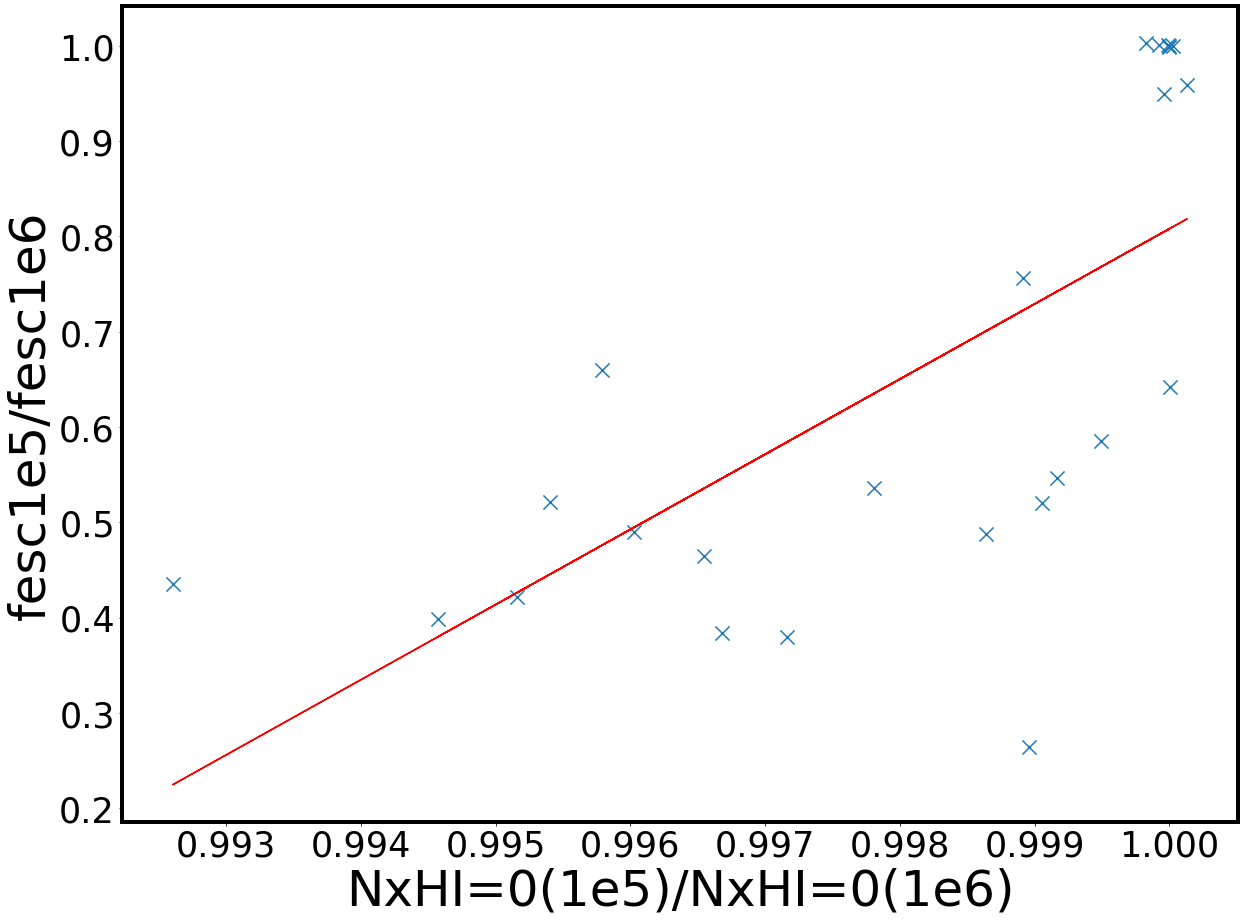

In [44]:
plt.scatter(rel_heights, rel_fesc, s=200, marker='x')
m, b = np.polyfit(rel_heights, rel_fesc, 1)
plt.plot(rel_heights, m*np.array(rel_heights) + b, color='red')
plt.ylabel('fesc1e5/fesc1e6', fontsize=50)
plt.xlabel('NxHI=0(1e5)/NxHI=0(1e6)', fontsize=50);

In [94]:
comparison_df['f_esc_1e6'].mean()
comparison_df['f_esc_1e6'].std()/np.sqrt(len(comparison_df))

0.12711545432343452

0.029673124277858176

In [89]:
comparison_df['f_esc_1e6'].describe()

count    25.000000
mean      0.127115
std       0.148366
min       0.000080
25%       0.053530
50%       0.083393
75%       0.171600
max       0.718286
Name: f_esc_1e6, dtype: float64